## Comic Book Cover Restoration?

Image restoration is the process of restoring the original image from the distorted one. Image restoration is of various kinds like:

- take a low-resolution image and convert it to the high-resolution image
- convert the black and white image to the coloured image
- restore the broken part of the image

We will focus this research spike on restoring the broken part of the image.

In [1]:
import fastai
import pathlib
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image, ImageDraw, ImageFont

In [2]:
path = pathlib.Path.cwd().parent
path_hr = path/'covers/justice_league/images'
path_lr = path/'covers/justice_league/crappy'

In [3]:
class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr
    def __call__(self, fn, i):
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img_open = PIL.Image.open(fn)
        targ_sz = resize_to(img_open, 96, use_min=True)
        img = img_open.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.\
          Draw(img).\
          text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

Memorize one thing, anything you do not include in the crappifier() , the model won’t learn to fix that.

The process to crappify the images can take a while, but fast.ai has a function called parallel. If you pass parallel a function name and a list of things to run that function on, it will run that function on them all in parallel. So, it will save a lot of time.

In [ ]:
crappify = crappifier(path_lr, path_hr)

il = ImageList.from_folder(path_hr)
parallel(crappify, il.items)

In [14]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

bs, size = 32, (600//6, 400//6)
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
               .transform(size=size, tfm_y=True)
               .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    
    return data

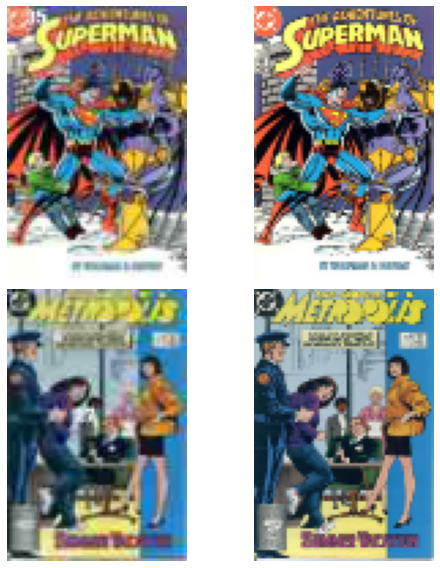

In [15]:
data_gen = get_data(bs,size)
data_gen.show_batch(2)

In [16]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()
def create_gen_learner():
    return unet_learner(data_gen,
                        arch, wd=wd,
                        blur=True,
                        norm_type=NormType.Weight,
                        self_attention=True,
                        y_range=y_range,
                        loss_func=loss_gen)

learn_gen = create_gen_learner()

In [17]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [ ]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))
learn_gen.show_results(rows=2)